# Using Polars for GIS

Big thanks to Krzysztof for an example of using Polars on geospatial data! The code is largely inspired from https://softwaremill.com/mapping-new-york-in-seconds-geospatial-magic-with-polar/

## Polars vs Pandas (and where GeoPolars fits)

**Pandas vs Polars in one line**: Pandas is the mature, Python‑first data frame library with a huge ecosystem, while Polars is a newer, Rust‑based, columnar, multi‑threaded engine designed for speed, memory efficiency, and scalable, SQL‑like query planning.

- **Execution model**
  - **Pandas**: eager, row/record‑oriented, each step runs immediately and often creates full intermediate `DataFrame`s. There is little automatic optimization – you manually decide the order of operations.
  - **Polars**: supports both eager and **lazy** APIs. With lazy frames, Polars builds a query plan and then optimizes it (projection/predicate pushdown, combining scans, etc.) before execution, similar to a SQL query engine.

- **Performance and parallelism**
  - **Pandas**: mostly **single‑threaded**; for parallel/distributed work you typically add another layer (Dask, Ray, Modin). On large joins and group‑bys this can become a bottleneck.
  - **Polars**: written in **Rust**, heavily **multi‑threaded**, and columnar. Operations over columns are automatically vectorized and parallelized, so joins, group‑bys, and aggregations on large tables are often several times faster than Pandas on the same machine.

- **Memory model**
  - **Pandas**: built on NumPy arrays; many operations create copies (sometimes unexpectedly). Wide tables plus intermediate results can quickly exhaust RAM.
  - **Polars**: uses Apache Arrow‑style columnar memory, minimizes copies, and prunes unused columns. This is especially helpful for GIS workloads where you join large attribute tables but only need a subset of columns.

- **API style**
  - **Pandas**: imperative and mutation‑oriented (`df['x'] = ...`, `df.drop(...)`), with a very rich ecosystem (GeoPandas, xarray, scikit‑learn, etc.).
  - **Polars**: expression‑based, focusing on **what** you want, not how to do it step‑by‑step. The lazy expression system is what allows the optimizer to reorder operations, push filters down, and parallelize.

### Why this matters for GIS

Geospatial (GIS) tasks like the NYC taxi example from the blog post involve:

- Reading **large, often multi‑file datasets** (e.g., several GB of CSV/Parquet).
- Doing **joins** and **aggregations** by spatial indices (tiles, H3 cells, census areas, etc.).
- Working on machines with **limited RAM**.

Here Polars tends to shine because:

- It can **load many files lazily**, combine them, and only materialize the columns/rows you actually need.
- The engine is **multi‑core by default**, so heavy group‑bys and joins can use all your CPU cores.
- The query optimizer can drop unused columns early and push filters close to the data, reducing both IO and memory.

Pandas is still excellent for smaller datasets and quick exploratory work, especially when you rely on libraries that expect Pandas/GeoPandas objects, but Polars gives you a more scalable engine when your data or computations grow.

### GeoPolars

- **GeoPandas** extends Pandas with geometry types and spatial operations.
- **GeoPolars** is an analogous effort for Polars: it adds geospatial awareness (geometry columns and spatial predicates/operations) on top of the Polars engine.

This is exciting because it combines:

- **Polars’ performance** (lazy execution, multi‑threaded, columnar storage), with
- **Geospatial operations** (spatial joins, predicates, etc.).

GeoPolars is **still under active development**, so APIs may change and not all GeoPandas‑style operations are available yet. However, it shows the direction the ecosystem is moving: bringing high‑performance, Polars‑style data processing directly into geospatial workflows.

The data is available here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [3]:
import requests
import zipfile
from pathlib import Path
import os

# Create data directory if it doesn't exist
Path("data").mkdir(exist_ok=True)

base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"
months = ["2016-01", "2016-02", "2016-03"]  # Add more as needed

for month in months:
    url = f"{base_url}{month}.parquet"
    filename = f"data/yellow_tripdata_{month}.parquet"
    
    print(f"Downloading {month}...")
    response = requests.get(url)
    
    with open(filename, 'wb') as f:
        f.write(response.content)
    
    print(f"✓ Saved to {filename}")

print("All downloads complete!")

✓ Saved to data/yellow_tripdata_2016-01.parquet
✓ Saved to data/yellow_tripdata_2016-02.parquet
✓ Saved to data/yellow_tripdata_2016-03.parquet
All downloads complete!


In [ ]:
Path("taxi_zones").mkdir(exist_ok=True)

url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
zip_filename = "taxi_zones/taxi_zones.zip"

# Download
print("Downloading...")
response = requests.get(url)
with open(zip_filename, 'wb') as f:
    f.write(response.content)

# Extract
print("Extracting...")
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("taxi_zones/")
    print("Files extracted:", zip_ref.namelist())

# Remove the zip file
os.remove(zip_filename)
print("✓ Done! ZIP file removed.")

Downloading...
Extracting...
Files extracted: ['taxi_zones.prj', 'taxi_zones.dbf', 'taxi_zones.shp', 'taxi_zones.shp.xml', 'taxi_zones.shx', 'taxi_zones.sbn', 'taxi_zones.sbx']
✓ Done! ZIP file removed.


In [1]:
# Install polars
!pip install polars

Defaulting to user installation because normal site-packages is not writeable


In [11]:
# Install fastparquet
!pip install fastparquet

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import polars as pl
import pandas as pd
import geopandas as gpd
import time


# Folder for local data (place your PARQUET files here)
data_dir = Path("data")

# Collect all CSV files under data/
file_paths = sorted(data_dir.glob("*.parquet"))
file_paths

[PosixPath('data/yellow_tripdata_2016-01.parquet'),
 PosixPath('data/yellow_tripdata_2016-02.parquet'),
 PosixPath('data/yellow_tripdata_2016-03.parquet')]

In [6]:
# Read NYC taxi zone shapefile
gdf = gpd.read_file("taxi_zones/taxi_zones.shp")
gdf['geometry_wkt'] = gdf['geometry'].to_wkt()

In [7]:
start = time.time()

#  Read each parquet file and select only the DOLocationID column
dataframes = []
for path in file_paths:
    # Read only the specific column to save memory
    df_chunk = pd.read_parquet(path, columns=["DOLocationID"], engine='fastparquet')
    dataframes.append(df_chunk)

# Concatenate all dataframes into one
pandas_df = pd.concat(dataframes, ignore_index=True)

pandas_df = pandas_df.groupby('DOLocationID').size().reset_index(name='count').sort_values('count', ascending=False)

sub_gdf = gdf[['geometry_wkt', 'LocationID']]

pandas_df_geo = pandas_df.merge(sub_gdf, left_on='DOLocationID', right_on='LocationID')
print(pandas_df_geo.head())
pandas_time = time.time() - start

   DOLocationID    count                                       geometry_wkt  \
0           161  1292196  POLYGON ((991081.026063 214453.698359, 990952....   
1           236  1194827  POLYGON ((995940.048319 221122.920427, 995812....   
2           237  1104459  POLYGON ((993633.442188 216961.016102, 993507....   
3           170  1101083  POLYGON ((991999.298609 210994.738831, 991972....   
4           230  1042770  POLYGON ((988786.87731 214532.094054, 988650.2...   

   LocationID  
0         161  
1         236  
2         237  
3         170  
4         230  


In [8]:
start = time.time()
# Inspired by: "Mapping New York in Seconds: Geospatial Magic with Polar"
# Adapted to Python + Polars and a local `data/` folder.
# Lazily scan each PARQUET and focus on DOLocationID column
lazy_frames = []
for path in file_paths:
    lf = pl.scan_parquet(path, low_memory=True)
    lf = lf.select([pl.col("DOLocationID")])
    lazy_frames.append(lf)

# Concatenate all lazy frames into one logical dataset
combined_lf = pl.concat(lazy_frames)

# Aggregate by DOLocationID
polars_df = combined_lf.group_by('DOLocationID').agg(pl.len().alias('count')).sort('count', descending=True)

# Collect the result into a materialized DataFrame
# (Polars will apply optimizations to the lazy plan before executing)
polars_df = polars_df.collect(streaming=True)

sub_gdf = pl.from_pandas(gdf[['geometry_wkt', 'LocationID']])

polars_df_geo = polars_df.join(sub_gdf, left_on='DOLocationID', right_on='LocationID')
print(polars_df_geo.head())
polars_time = time.time() - start

shape: (5, 3)
┌──────────────┬────────┬─────────────────────────────────┐
│ DOLocationID ┆ count  ┆ geometry_wkt                    │
│ ---          ┆ ---    ┆ ---                             │
│ i64          ┆ u32    ┆ str                             │
╞══════════════╪════════╪═════════════════════════════════╡
│ 1            ┆ 51769  ┆ POLYGON ((933100.918353 192536… │
│ 2            ┆ 62     ┆ MULTIPOLYGON (((1033269.243591… │
│ 3            ┆ 1993   ┆ POLYGON ((1026308.769507 25676… │
│ 4            ┆ 185204 ┆ POLYGON ((992073.466797 203714… │
│ 5            ┆ 187    ┆ POLYGON ((935843.310493 144283… │
└──────────────┴────────┴─────────────────────────────────┘


/tmp/ipykernel_28953/395607671.py:19: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  polars_df = polars_df.collect(streaming=True)


In [9]:
print(f"Polars: {polars_time:.2f}s")
print(f"Pandas: {pandas_time:.2f}s")
print(f"Speedup: {pandas_time/polars_time:.2f}x")


Polars: 0.21s
Pandas: 1.28s
Speedup: 6.19x


Now, we can see the number of dropoffs per `DoLocationID`

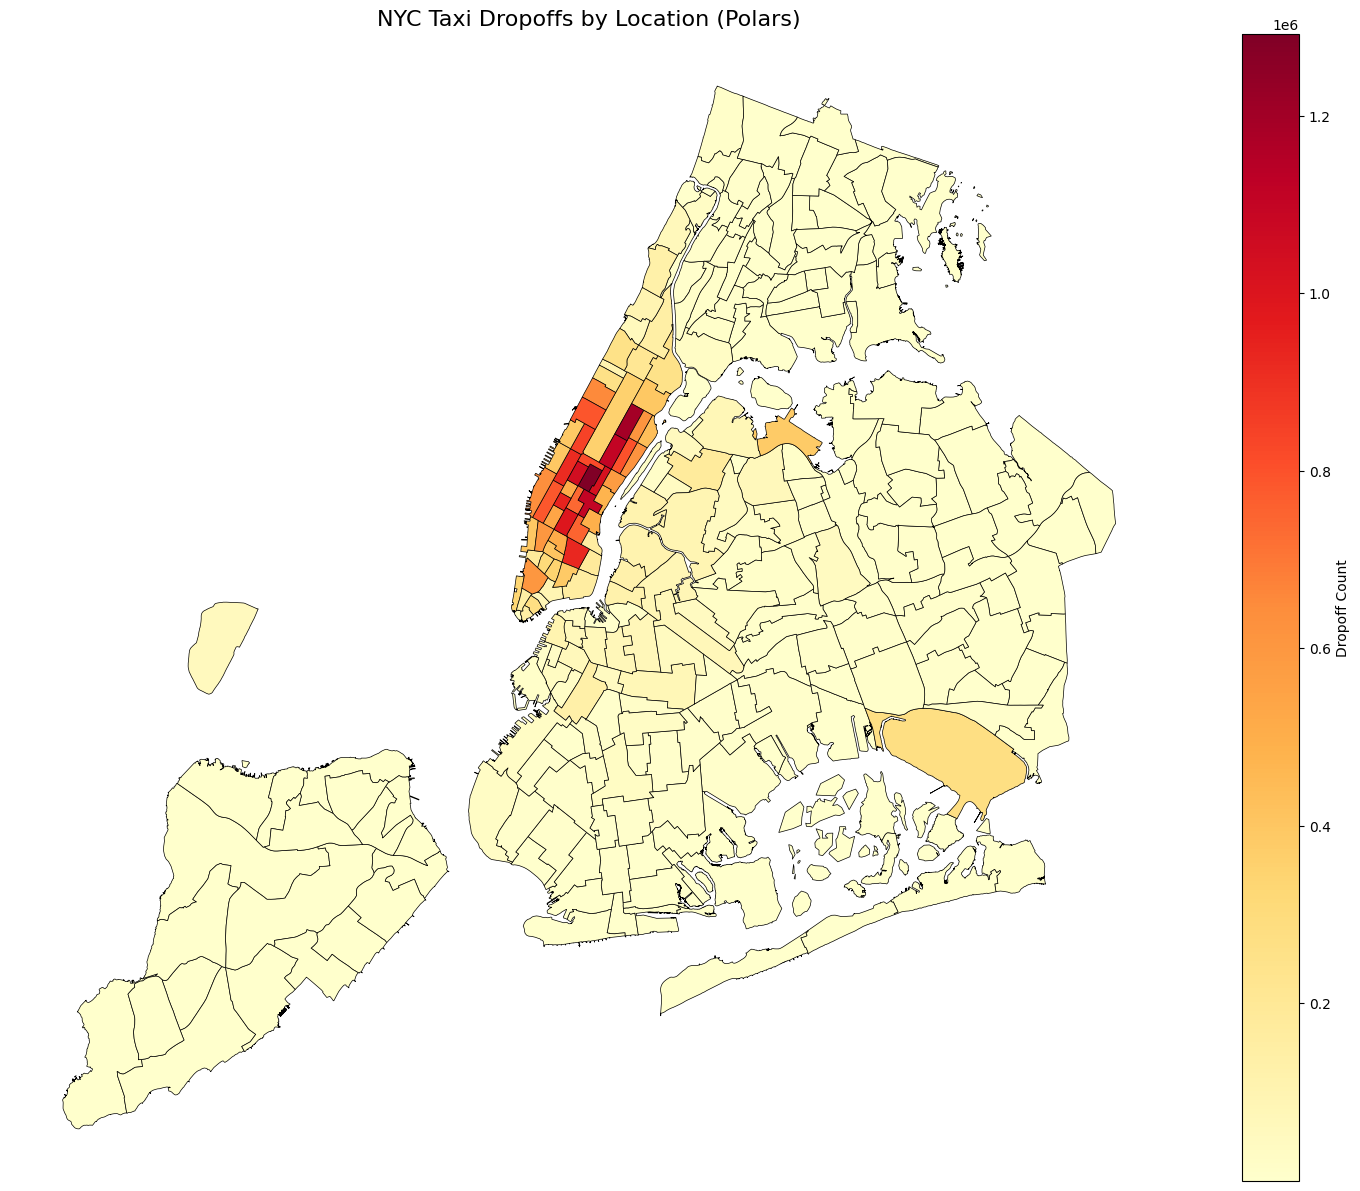

In [10]:
from shapely import wkt
import matplotlib.pyplot as plt
# Convert Polars to Pandas for GeoPandas compatibility
polars_df_geo_pd = polars_df_geo.to_pandas()

# Convert WKT strings back to geometry objects
polars_df_geo_pd['geometry'] = polars_df_geo_pd['geometry_wkt'].apply(wkt.loads)

# Create GeoDataFrame
geo_plot_df = gpd.GeoDataFrame(polars_df_geo_pd, geometry='geometry')

# Plot
fig, ax = plt.subplots(figsize=(15, 12))
geo_plot_df.plot(
    column='count', 
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend_kwds={'label': "Dropoff Count", 'orientation': "vertical"}
)
plt.title('NYC Taxi Dropoffs by Location (Polars)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()